# [5] Blender Dataset Analysis  
이번 장에서는 NeRF에서 대표적으로 쓰인 블렌더 데이터셋에 대해 살펴보고, 이것이 모델에 입력되기 전까지의 과정을 추적합니다.  
이 데이터셋의 가장 큰 특징은 오브젝트를 촬영한 카메라의 위치를 나타내는 행렬(Cam to World Matrix)이 주어져있다는 것입니다.  
블렌더의 가상공간에서 3D 오브젝트를 불러온 뒤, 원하는 시점에서 바라본 모습을 렌더링한 것이기 때문에 이 값을 알 수 있는 것입니다.  
실상황에서는 카메라의 위치를 알 수 없으니 COLMAP 알고리즘을 통하여 camera pose estimation을 해야 Cam to World Matrix를 알 수 있습니다.
## 1. 필요한 라이브러리 불러오기

In [1]:
import os
import cv2
import time
import json
import random
import numpy as np
import imageio.v2 as imageio

import torch
import torch.nn as nn
import torch.nn.functional as F

import argparse
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [2]:
print(os.getcwd())

/home/white/Desktop/white/NeRF


## 2. argparse

In [3]:
# 이 함수는 `argparse.ArgumentParser` 객체를 생성하고, 그 안에 여러 인자를 추가한 뒤, 최종적으로 파서(parser) 객체를 리턴합니다.  
# 다른 곳에서 `config_parser()`를 호출하여, 그 결과로 리턴된 `parser` 객체를 통해 명령줄 인자를 파싱하게 됩니다.
def config_parser():
    parser = argparse.ArgumentParser() # parser라는 이름의 ArgumentParser 객체 생성

    parser.add_argument("--expname", type=str, 
                        help='experiment name') # 실험 이름
    parser.add_argument("--basedir", type=str, default='./logs/', 
                        help='where to store ckpts and logs') # 체크포인트와 로그 파일을 저장할 디렉토리
    parser.add_argument("--datadir", type=str, default='./data/llff/fern', 
                        help='input data directory') # 학습과 테스트에 사용할 데이터셋 디렉토리

    # training options
    parser.add_argument("--netdepth", type=int, default=8, # coarse 네트워크 레이어 개수
                        help='layers in network')
    parser.add_argument("--netwidth", type=int, default=256, # coarse 네트워크 채널 수
                        help='channels per layer')
    parser.add_argument("--netdepth_fine", type=int, default=8, # fine 네트워크 레이어 개수
                        help='layers in fine network')
    parser.add_argument("--netwidth_fine", type=int, default=256, 
                        help='channels per layer in fine network') # fine 네트워크 채널 수
    parser.add_argument("--N_rand", type=int, default=32*32*4, 
                        help='batch size (number of random rays per gradient step)') # 한 번의 학습 스텝마다 학습할 광선의 개수
    parser.add_argument("--lrate", type=float, default=5e-4, 
                        help='learning rate') # 초기 학습률
    parser.add_argument("--lrate_decay", type=int, default=250, 
                        help='exponential learning rate decay (in 1000 steps)') # 지수적 학습률 감소를 적용할 스텝의 수 (250 스텝마다 감소율 적용)
    parser.add_argument("--chunk", type=int, default=1024*32, 
                        help='number of rays processed in parallel, decrease if running out of memory') # 한 번에 병렬 처리할 광선의 개수
    parser.add_argument("--netchunk", type=int, default=1024*64, 
                        help='number of pts sent through network in parallel, decrease if running out of memory') # 한 번에 병렬처리할 샘플의 개수
    parser.add_argument("--no_batching", action='store_true', 
                        help='only take random rays from 1 image at a time') # 여러 이미지에서 광선을 샘플링하지 않고, 한 장의 이미지에서만 광선을 뽑아옴
    parser.add_argument("--no_reload", action='store_true', 
                        help='do not reload weights from saved ckpt') # 웨이트 파일을 불러오지 않음
    parser.add_argument("--ft_path", type=str, default=None, 
                        help='specific weights npy file to reload for coarse network') # fine-tuning 할 때 모델의 가중치를 불러오는 경로

    # rendering options
    parser.add_argument("--N_samples", type=int, default=64, 
                        help='number of coarse samples per ray') # coarse 학습 단계에서 하나의 광선에서 뽑을 샘플의 개수 (디폴트: 64)
    parser.add_argument("--N_importance", type=int, default=0,
                        help='number of additional fine samples per ray') # fine 학습 단계에서 하나의 광선에서 뽑을 샘플의 개수 (디폴트: 128)
    parser.add_argument("--perturb", type=float, default=1.,
                        help='set to 0. for no jitter, 1. for jitter') # 난수(jitter)를 추가하여 샘플링 위치를 조금씩 흔들어주는 정도. 0이면 완전 균일, 1이면 논문에서 제안한 섭동(perturb)
    parser.add_argument("--use_viewdirs", action='store_true', 
                        help='use full 5D input instead of 3D') # 방향 정보를 추가로 포함할지 여부 (True이면 5D 입력)
    parser.add_argument("--i_embed", type=int, default=0, 
                        help='set 0 for default positional encoding, -1 for none') # 포지셔널 인코딩 방식 선택. 0이면 기본, -1이면 사용 안 함.
    parser.add_argument("--multires", type=int, default=10, 
                        help='log2 of max freq for positional encoding (3D location)') # 위치 정보(3차원)에 대한 포지셔널 인코딩에서 사용하는 옥타브 수 (L)
    parser.add_argument("--multires_views", type=int, default=4, 
                        help='log2 of max freq for positional encoding (2D direction)') # 방향 정보(3차원)에 대한 포지셔널 인코딩에서 사용하는 옥타브 수 (L)
    parser.add_argument("--raw_noise_std", type=float, default=0., 
                        help='std dev of noise added to regularize sigma_a output, 1e0 recommended') # 밀도(sigma)를 정규화 하기 위해 노이즈를 추가할 때 사용하는 표준편차(std dev)

    parser.add_argument("--render_only", action='store_true', 
                        help='do not optimize, reload weights and render out render_poses path') # 학습을 수행하지 않고, 저장된 가중치를 불러와 렌더링만 실행
    parser.add_argument("--render_test", action='store_true', 
                        help='render the test set instead of render_poses path') # 학습을 수행하지 않고, 테스트 세트를 렌더링
    parser.add_argument("--render_factor", type=int, default=0, 
                        help='downsampling factor to speed up rendering, set 4 or 8 for fast preview') # 렌더링 시 해상도를 낮춰 다운샘플링을 할 때, 이미지의 축소 비율 (0이면 사용 안 함)

    # training options
    parser.add_argument("--precrop_iters", type=int, default=0,
                        help='number of steps to train on central crops') # 이미지 중앙 부분만 잘라내 중심부만 집중적으로 학습하는 pre-cropping에 대해, 이 방식으로 학습할 스텝의 수
    parser.add_argument("--precrop_frac", type=float,
                        default=.5, help='fraction of img taken for central crops') # 이미지를 얼마나 크게 잘라서 학습할지 결정 (0.5의 경우 중앙 영역에서 50%만 사용)

    # dataset options
    parser.add_argument("--dataset_type", type=str, default='llff', 
                        help='options: llff / blender / deepvoxels') # llff, blender, deepvoxels 등 원하는 데이터셋 선택
    parser.add_argument("--testskip", type=int, default=8, 
                        help='will load 1/N images from test/val sets, useful for large datasets like deepvoxels') # 테스트 데이터가 방대할 때 1/N 이미지만 로드하여 사용 (train의 경우 이 비율을 무시)

    ## deepvoxels flags
    parser.add_argument("--shape", type=str, default='greek', 
                        help='options : armchair / cube / greek / vase') # deepvoxels 데이터셋을 사용할 때, 어떤 오브젝트를 사용할지 결정

    ## blender flags
    parser.add_argument("--white_bkgd", action='store_true', 
                        help='set to render synthetic data on a white bkgd (always use for dvoxels)') # 이미지의 배경을 흰색으로 할지 여부
    parser.add_argument("--half_res", action='store_true', 
                        help='load blender synthetic data at 400x400 instead of 800x800') # 800x800 대신 400x400으로 해상도를 절반으로 낮춰서 학습 시간을 단축

    ## llff flags
    parser.add_argument("--factor", type=int, default=8, 
                        help='downsample factor for LLFF images') # LLFF 이미지를 얼마나 다운샘플링할지(해상도 감소) 결정.
    parser.add_argument("--no_ndc", action='store_true', 
                        help='do not use normalized device coordinates (set for non-forward facing scenes)') # NDC (Normalized Device Coordinates) 사용 여부 (카메라가 전방을 향해 있지 않은 데이터셋일 경우나, 구체적인 좌표 변환 방식이 다를 때 활용)
    parser.add_argument("--lindisp", action='store_true', 
                        help='sampling linearly in disparity rather than depth') # 깊이에에 대한 선형 샘플링 대신 깊이의 역수인 disparity(1/Depth)에 대한 선형 샘플링 여부 (가까운 위치의 좌표를 더 많이 추출)
    parser.add_argument("--spherify", action='store_true', 
                        help='set for spherical 360 scenes') # 장면이 360도로 되어있을 때 설정
    parser.add_argument("--llffhold", type=int, default=8, 
                        help='will take every 1/N images as LLFF test set, paper uses 8') # LLFF에서 테스트 세트를 만들기 위해 1/N 이미지 간격만큼 나누는 옵션 (디폴트 8)

    # logging/saving options
    parser.add_argument("--i_print",   type=int, default=100, 
                        help='frequency of console printout and metric loggin') # 콘솔에 학습 상태를 출력하는 빈도 (단위는 스텝)
    parser.add_argument("--i_img",     type=int, default=500, 
                        help='frequency of tensorboard image logging') # 텐서보드에 이미지를 로그하는 빈도
    parser.add_argument("--i_weights", type=int, default=10000, 
                        help='frequency of weight ckpt saving') # 모델 가중치를 저장하는 빈도
    parser.add_argument("--i_testset", type=int, default=50000, 
                        help='frequency of testset saving') # 테스트 셋을 돌려서 결과를 저장하는 빈도
    parser.add_argument("--i_video",   type=int, default=50000,
                        help='frequency of render_poses video saving') # render_poses를 영상으로 만들어 저장하는 빈도

    return parser

In [4]:
parser = config_parser() # 위에서 정의한 config_parser() 함수를 호출해 객체 생성
args = parser.parse_args(args=[]) # args = []를 통해 모든 인자가 디폴트 값인채로 args 객체 생성
args.config = 'configs/lego.txt' # args에 config라는 속성을 추가. (설정 파일의 경로 지정)

"""
<configs/lego.txt>
expname = blender_paper_lego
basedir = ./logs
datadir = ./data/nerf_synthetic/lego
dataset_type = blender

no_batching = True

use_viewdirs = True
white_bkgd = True
lrate_decay = 500

N_samples = 64
N_importance = 128
N_rand = 1024

precrop_iters = 500
precrop_frac = 0.5

half_res = True
"""

'\n<configs/lego.txt>\nexpname = blender_paper_lego\nbasedir = ./logs\ndatadir = ./data/nerf_synthetic/lego\ndataset_type = blender\n\nno_batching = True\n\nuse_viewdirs = True\nwhite_bkgd = True\nlrate_decay = 500\n\nN_samples = 64\nN_importance = 128\nN_rand = 1024\n\nprecrop_iters = 500\nprecrop_frac = 0.5\n\nhalf_res = True\n'

In [5]:
parser = config_parser() # 먼저 config_parser() 함수를 호출해 parser(ArgumentParser 객체)를 받습니다.
args = parser.parse_args(args=[]) # parse_args(args=[])는 빈 리스트를 인자로 넘기는 것이므로, 실제로는 명령줄 인자를 주지 않은 채 모든 인자를 기본값으로 파싱합니다.

# args.config라는 속성을 추가로 지정하여, config_parser에서 정의된 인자 외에 **‘config’**라는 속성을 하나 더 줍니다.
# 'configs/lego.txt'라는 텍스트 파일(설정 파일) 경로를 저장해 둡니다.
args.config = 'configs/lego.txt'
# load config
with open(args.config, 'r') as fp: # lego.txt 파일 불러오기
    lines = fp.readlines() # fp.readlines()로 모든 줄을 읽어 lines 리스트를 얻습니다.
    lines = [line.strip() for line in lines] # line.strip()을 통해 앞뒤 공백을 제거하고,
    lines = [line.split(' = ') for line in lines if len(line)>0] # ' = '을 기준으로 split해서 ['expname', 'lego'] 같은 구조로 만듭니다. (단순히 ' = ' 구분자를 사용해 key/value로 나누는 방식)

configs = {} # 그런 다음 configs = {} 딕셔너리를 만든 뒤
for line in lines: # 각 줄(line)을 순회하면서
    configs[line[0]] = line[1] # configs[line[0]] = line[1]로 key-value 형태로 저장합니다.

for key, value in configs.items():
    print(f"{key}: {value}")

expname: blender_paper_lego
basedir: ./logs
datadir: ./data/nerf_synthetic/lego
dataset_type: blender
no_batching: True
use_viewdirs: True
white_bkgd: True
lrate_decay: 500
N_samples: 64
N_importance: 128
N_rand: 1024
precrop_iters: 500
precrop_frac: 0.5
half_res: True


In [6]:
args.expname = configs['expname']
args.basedir = configs['basedir']
args.datadir = configs['datadir']
args.dataset_type = configs['dataset_type']
args.no_batching = configs['no_batching']
args.use_viewdirs = configs['use_viewdirs']
args.white_bkgd = configs['white_bkgd']
args.lrate_decay = int(configs['lrate_decay'])
args.N_samples = int(configs['N_samples'])
args.N_importance = int(configs['N_importance'])
args.N_rand = int(configs['N_rand'])
args.precrop_iters = int(configs['precrop_iters'])
args.precrop_frac = float(configs['precrop_frac'])
args.half_res = configs['half_res']
args.no_reload = True

for key, value in vars(args).items():
    print(f"{key}: {value}")

device = torch.device("cuda")
DEBUG=False
print(device)

expname: blender_paper_lego
basedir: ./logs
datadir: ./data/nerf_synthetic/lego
netdepth: 8
netwidth: 256
netdepth_fine: 8
netwidth_fine: 256
N_rand: 1024
lrate: 0.0005
lrate_decay: 500
chunk: 32768
netchunk: 65536
no_batching: True
no_reload: True
ft_path: None
N_samples: 64
N_importance: 128
perturb: 1.0
use_viewdirs: True
i_embed: 0
multires: 10
multires_views: 4
raw_noise_std: 0.0
render_only: False
render_test: False
render_factor: 0
precrop_iters: 500
precrop_frac: 0.5
dataset_type: blender
testskip: 8
shape: greek
white_bkgd: True
half_res: True
factor: 8
no_ndc: False
lindisp: False
spherify: False
llffhold: 8
i_print: 100
i_img: 500
i_weights: 10000
i_testset: 50000
i_video: 50000
config: configs/lego.txt
cuda


## 3. 블렌더 데이터셋 분석
이제 본격적으로 블렌더 데이터셋의 구조를 살펴보겠습니다.  
우선 아래의 pose_spherical 함수가 기억나지 않는다면 1장을 복습하세요.  

In [7]:
# Z축으로 t만큼 이동
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

# X축 기준 phi만큼 회전
rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

# Y축 기준 -theta만큼 회전
rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius) # Z축으로 t만큼 이동
    c2w = rot_phi(phi/180.*np.pi) @ c2w # X축으로 phi만큼 회전
    c2w = rot_theta(theta/180.*np.pi) @ c2w # Y축으로 -theta만큼 회전
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w # world 좌표계 x-axis를 반대로, y-axis & z-axis 바꾸기
    # 즉 X축으로 -phi, Y축으로 -theta만큼 회전한 후 Y, Z축 바꾸기
    # look at point는 보통 원점, 혹은 원점 근처. 따라서 camera 가 바라보는 방향은 camera 의 - z-axis
    return c2w

데이터셋에 들어있는 메타 데이터와 실제 이미지를 살펴보겠습니다.

{'file_path': './train/r_0', 'rotation': 0.012566370614359171, 'transform_matrix': [[-0.9999021887779236, 0.004192245192825794, -0.013345719315111637, -0.05379832163453102], [-0.013988681137561798, -0.2996590733528137, 0.95394366979599, 3.845470428466797], [-4.656612873077393e-10, 0.9540371894836426, 0.29968830943107605, 1.2080823183059692], [0.0, 0.0, 0.0, 1.0]]}
./data/nerf_synthetic/lego/./train/r_0.png
(800, 800, 4)
100
[0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171, 0.012566370614359171,

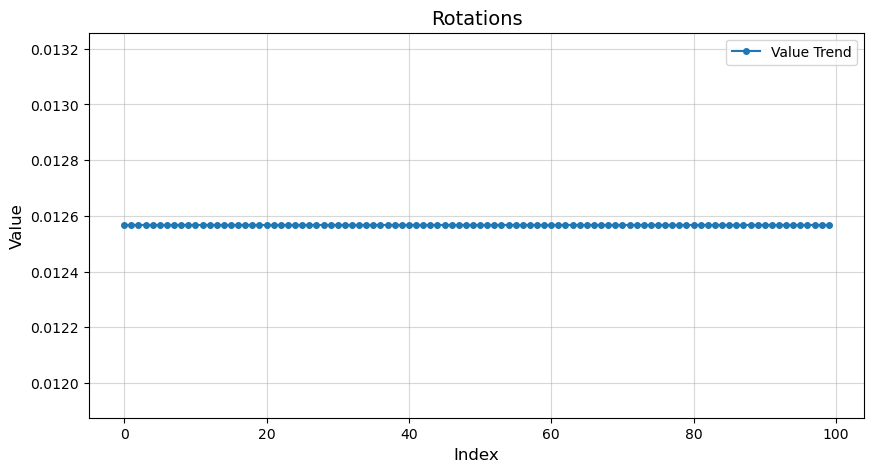

In [8]:
# data practice
_datadir = './data/nerf_synthetic/lego'

# 
with open(os.path.join(_datadir, 'transforms_train.json'), 'r') as fp:
    meta = json.load(fp)

_frames = meta['frames']
_frame = _frames[0]
print(_frame) # 하나의 이미지에 대한 메타 데이터

_fname = os.path.join(_datadir, _frame['file_path']+'.png')
print(_fname) # 이미지 파일 경로

img = imageio.imread(_fname)
print(img.shape) # 4 channel rgba

print(len(meta['frames'])) # 이미지는 총 100장

rotations = []
transform_matrixes = []

for i in range(len(meta['frames'])):
    rotations.append(meta['frames'][i]['rotation'])
    transform_matrixes.append(meta['frames'][i]['transform_matrix'])

print(rotations)
print(transform_matrixes)

# rotations 도표화
plt.figure(figsize=(10, 5))
plt.plot(rotations, marker='o', linestyle='-', markersize=4, label='Value Trend')
plt.title("Rotations", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

(10, 800, 800, 4)


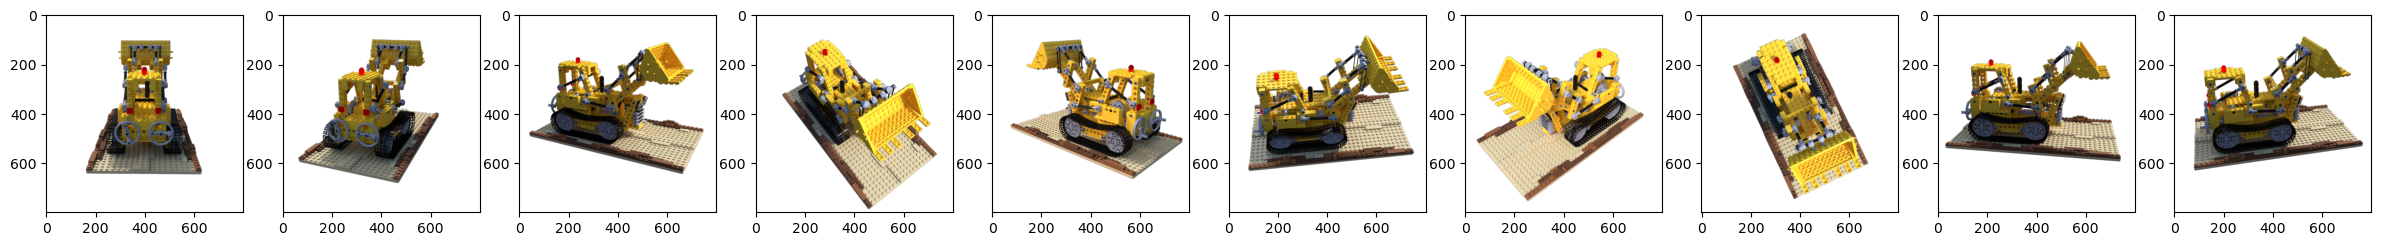

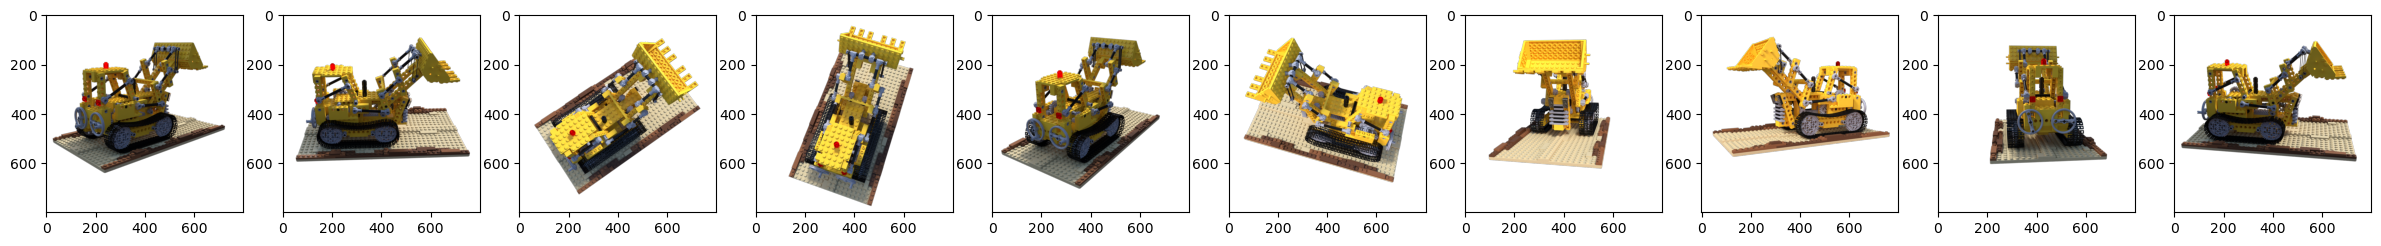

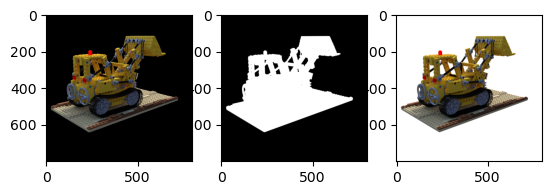

In [9]:
fig, axis = plt.subplots(1, 10, figsize=(30,300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame['file_path']+'.png')
    img = imageio.imread(_fname)
    axis[i].imshow(img)

random.shuffle(_frames)
fig, axis = plt.subplots(1, 10, figsize=(30,300))
imgs = []
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame['file_path']+'.png')
    img = imageio.imread(_fname)
    imgs.append(img)
    axis[i].imshow(img)

imgs = (np.array(imgs) / 255.).astype(np.float32)
print(imgs.shape)

imgs_orig = imgs[...,:3] # rgb값만 저장
imgs_mask = imgs[...,-1] # 불투명도값만 저장
imgs = imgs[...,:3]*imgs[...,-1:] + (1-imgs[...,-1:]) # 흰 배경으로

fig, axis = plt.subplots(1,3)
axis[0].imshow(imgs_orig[0])
axis[1].imshow(imgs_mask[0], cmap='gray')
axis[2].imshow(imgs[0])

### **load_blender_data()**  
블렌더 데이터셋 경로를 입력 받아 다음 값을 반환합니다.  
- **imgs**: train, test, val 데이터의 모든 이미지들 [N, H, W, 4(rgb&alpha)]  
- **poses**: train, test, val 데이터의 모든 카메라 위치(c2w matrix) [N, 4, 4]  
- **render_poses**: 위에서 정의한 pose_spherical 함수를 통해 우리가 보고 싶은 카메라 위치 [n, 4, 4]  
- **[H, W, focal]**: 카메라 내부 파라미터를 구하기 위한 이미지 세로 픽셀 수(H), 가로 픽셀 수(W), focal length (focal)  
- **i_split**: train, test, val 데이터의 인덱스 (testskip에 따라 val, test는 건너 뛰며 sparse하게 샘플링합니다.)  

In [10]:
def load_blender_data(basedir, half_res=False, testskip=1):
    splits = ['train', 'val', 'test']

    metas = {} # 메타 정보는 여기에 저장한다.
    for s in splits:
        with open(os.path.join(basedir, 'transforms_{}.json'.format(s)), 'r') as fp:
            metas[s] = json.load(fp)
    # {'train' : 'transforms_train_json', ...}

    all_imgs = [] # train, test, val의 모든 이미지를 넣는 리스트
    all_poses = [] # 카메라 포즈에 대한 모든 행렬을 넣는 리스트
    counts = [0]

    for s in splits: # train, val, test
        meta = metas[s]
        imgs = []
        poses = []
        if s=='train' or testskip==0:
            skip = 1 # train 데이터를 만들 때는 하나도 건너뛰지 않고 모두 저장
        else:
            skip = testskip # train이 아닐 경우 testskip만큼 건너 뛰면서 데이터 샘플링 진행

        for frame in meta['frames'][::skip]:
            fname = os.path.join(basedir, frame['file_path'] + '.png') # 이미지 파일 경로를 리스트에 저장
            imgs.append(imageio.imread(fname)) # 이미지를 리스트에 저장
            poses.append(np.array(frame['transform_matrix'])) # cam to world 매트릭스를 리스트에 저장

        imgs = (np.array(imgs) / 255.).astype(np.float32) # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32)
        counts.append(counts[-1] + imgs.shape[0]) # start index, end of train index, end of val index, end of test index
        # counts = [0, 200, 210, 220]

        # for문 이전에 선언한 모든 데이터셋을 담아둘 리스트에 이미지와 c2w 매트릭스 저장
        all_imgs.append(imgs)
        all_poses.append(poses)
    
    i_split = [np.arange(counts[i], counts[i+1]) for i in range(3)] # index for each split(train, val, test)
    
    imgs = np.concatenate(all_imgs, 0)
    poses = np.concatenate(all_poses, 0)
    
    H, W = imgs[0].shape[:2] # 이미지의 세로, 가로축 길이
    camera_angle_x = float(meta['camera_angle_x'])
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    # focal lenth = (1/2 * width) / (tan(1/2 * theta)) (theta = camera_angle_x)
    
    render_poses = torch.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)
    # rendering 할 pose 미리 정의
    # pose_spherical를 통해 cam to world 매트릭스를 만든다.
    # 첫 번째 인자 angle은 X축 좌우 회전 각도 (-180부터 180까지)
    # 두 번째 인자는 Y축 기준 30도 회전 (pose_sherical은 X, Y의 회전 각도가 반대!)

    # 이미지를 1/2 스케일로 줄이는 것 (학습 속도를 높이기 위함)
    if half_res:
        H = H//2
        W = W//2
        # important - change focal
        focal = focal/2. # 이미지가 작아지면 focal도 당연히 1/2가 된다!

        imgs_half_res = np.zeros((imgs.shape[0], H, W, 4))
        for i, img in enumerate(imgs):
            imgs_half_res[i] = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)
        imgs = imgs_half_res

        
    return imgs, poses, render_poses, [H, W, focal], i_split

블렌더 데이터셋의 경우 이미지의 높이, 너비, 초점 거리는 아래와 같습니다.  
(**주의해야 할 점**은, args.half_res를 True로 하여 위의 세 값이 모두 절반이 되었다는 것입니다.)
- **H**: 400
- **W**: 400
- **focal**: 555.555  

In [11]:
images, poses, render_poses, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
# Cast intrinsics to right types
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]
print(hwf)

[400, 400, 555.5555155968841]


In [12]:
print(i_split) # 이중 어레이
print(i_split[0][0]) # train 이미지 첫 인덱스 (100장)
print(i_split[1][0]) # val 이미지 첫 인덱스 (13장)
print(i_split[2][0]) # test 이미지 첫 인덱스 (20장)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]), array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137])]
0
100
113


In [13]:
print(len(images)) # train, val, test 전체 이미지 개수
print(images[0].shape)
print(len(poses)) # train, val, test 전체 c2w 개수
print(poses[0])

138
(400, 400, 4)
138
[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [14]:
print(len(render_poses))
print(render_poses[0])

40
tensor([[ 1.0000e+00,  6.1232e-17, -1.0606e-16, -4.2423e-16],
        [-1.2246e-16,  5.0000e-01, -8.6603e-01, -3.4641e+00],
        [ 0.0000e+00,  8.6603e-01,  5.0000e-01,  2.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


In [15]:
print(H)
print(W)
print(focal)
print(hwf)

400
400
555.5555155968841
[400, 400, 555.5555155968841]


### 카메라 내부 파라미터
H, W, focal을 통해 구한 카메라 내부 파라미터는 다음과 같습니다.  
공식이 기억나지 않는다면 2장을 복습해주세요.

In [16]:
K = np.array([
    [focal, 0, 0.5*W],
    [0, focal, 0.5*H],
    [0, 0, 1]
])
print(K)

[[555.5555156   0.        200.       ]
 [  0.        555.5555156 200.       ]
 [  0.          0.          1.       ]]


### 카메라 위치 시각화
단순히 c2w 행렬을 출력해보는 것만으로는 시각적으로 이해하기 힘들기 때문에, 시각화 라이브러리를 이용하여 이미지가 촬영된 카메라의 위치를 가시화 해보겠습니다.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.camera as pc
import pytransform3d.transformations as pt
from pytransform3d.plot_utils import plot_vector

def plot_cam(figsize, poses, elev, azim, axis_lim, plot_label):
    # 3D 플롯 생성
    fig = plt.figure(figsize=(figsize, figsize))
    ax = fig.add_subplot(111, projection='3d')

    # 월드 좌표계 그리기
    pt.plot_transform(ax=ax, A2B=np.eye(4), s=0.3, name="World")

    # 보기 편하도록 뷰 설정
    ax.view_init(elev=elev, azim=azim)

    # 카메라 위치 저장용 배열 (최대/최소 좌표 계산)
    all_camera_positions = []

    for i, c2w in enumerate(poses):
        try:
            c2w = np.array(c2w) # 텐서를 넘파이로 변환
            # 카메라 좌표계 플롯
            if plot_label:
                ax = pt.plot_transform(A2B=c2w, ax=ax, s=0.3, name=f"Step {i}")  # s 값 조정
                # 카메라 프러스텀 플롯 (가상 이미지 거리 키움)
                pc.plot_camera(
                    ax=ax,
                    cam2world=c2w,
                    M=K,
                    virtual_image_distance=0.1,
                    label=f"Step {i}",
                    color="red",
                    alpha=0.5
                )

            else:
                ax = pt.plot_transform(A2B=c2w, ax=ax, s=0.3)
                pc.plot_camera(
                    ax=ax,
                    cam2world=c2w,
                    M=K,
                    virtual_image_distance=0.1,
                    color="red",
                    alpha=0.5
                )
        except:
            continue

    ax.set_xlim([-axis_lim, axis_lim])
    ax.set_ylim([-axis_lim, axis_lim])
    ax.set_zlim([-axis_lim, axis_lim])

    ax.set_box_aspect((1, 1, 1))  # 축 비율 균일화
    # ax.auto_scale_xyz(all_camera_positions[:, 0], all_camera_positions[:, 1], all_camera_positions[:, 2])  # 자동 스케일 조정

    plt.show()

먼저 전체 데이터셋의 위치 정보가 담긴 **poses**를 가시화 해보겠습니다.

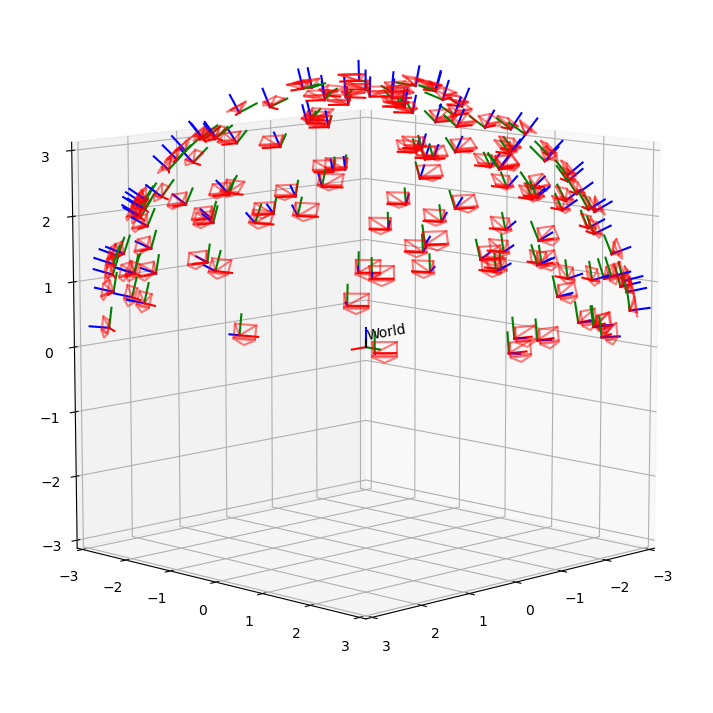

In [18]:
plot_cam(9, poses, 10, 45, 3, False)

이제 test 데이터셋의 카메라 앵글과 그에 대응되는 촬영된 이미지를 하나씩 비교해보겠습니다.

In [19]:
# 테스트 데이터셋에서 카메라의 위치와 보이는 면 비교하기
for i in range(i_split[2][0], i_split[2][-1]):
    plt.imshow(images[i])
    plot_cam(5.28, [poses[i]], 90, 0, 3, False)

우리가 보고싶은 각도의 카메라는 어떻게 배열되어있는지 가시화 해보겠습니다.

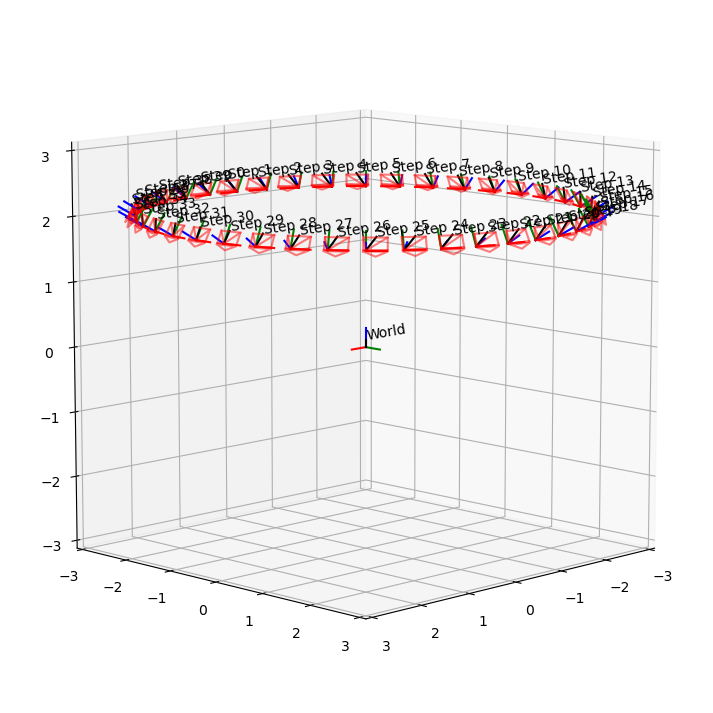

In [20]:
plot_cam(9, render_poses, 10, 45, 3, True)

## 4. 광선(Ray) 생성하기

### 1) 광선(Ray)의 정의
#### (1) 광선이란?
- **광선(Ray)**: 하나의 픽셀에서 발사되는 일직선 형태의 빛  
- 3D 공간에서 **시작점**과 **방향벡터**의 두 가지 요소로 정의됨  


### 2) NeRF가 광선을 계산하는 방법

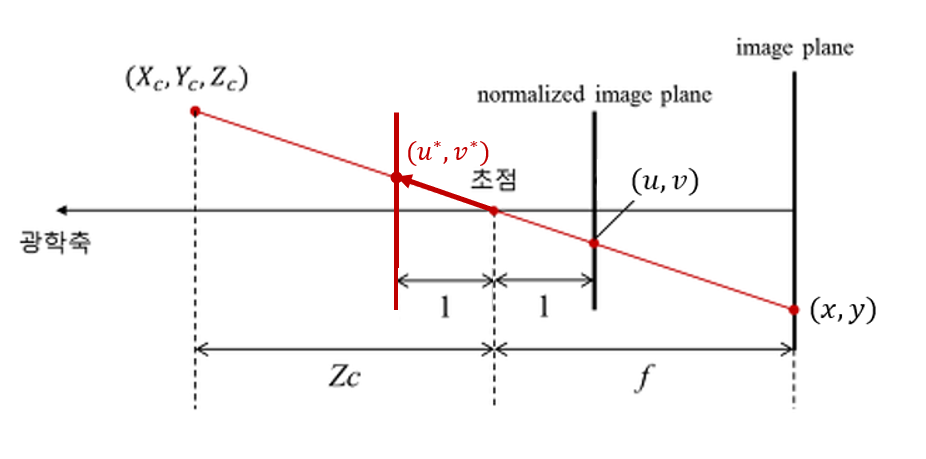

#### (1) 이미지 플레인(Image Plane) 설정
1. **이미지 플레인**은 카메라의 초점(focal point)에서 초점 거리$f$만큼 떨어진 위치에 존재  
   - 예:$Z = -f$인 지점에 이미지 플레인이 위치  
2. 이미지 플레인의 픽셀 개수는 가로$W$개, 세로$H$개  
3. **원점(0, 0)** 은 이미지 플레인의 **왼쪽 위 모서리**에 위치  

> 실제 물리 카메라에서 **LCD 모니터**를 떠올리면 이해하기 쉬움.  



#### (2) 이미지 플레인을 노멀 플레인(Normalized Plane)으로 매핑
1. **이미지 플레인의 원점**이 왼쪽 위 모서리에 위치하는 것과 달리,  
   **노멀 플레인**의 원점은 **이미지 플레인의 중심(초점과 수직으로 정렬되는 위치)**  
2. 일반적인 카메라 이론에서는 노멀 플레인이 초점으로부터 **1 단위 거리 앞**에 위치 ($z = 1$)  
3. **NeRF에서는 노멀 플레인을 초점보다 1 단위 거리 뒤 ($z = -1$) 에 배치**  
   - 그림상의 이미지 플레인 좌표$(x, y)$를$(u, v)$가 아닌$(u^*, v^*)$로 매핑  
   - 노멀 플레인이 초점 뒤에 있으므로 상이 반전되기 때문에,$y$좌표 또한 음수로 반전  
4. 이렇게 노멀 플레인을 정의하는 이유:  
   - 카메라의 초점 좌표가$(0,0,0)$이므로 이 점을 **광선의 시작점**으로 이해할 수 있음  
   - 초점$(0,0,0)$과 노멀 플레인 상의 좌표$(u^*, v^*, -1)$을 잇는 **벡터**가 바로 **광선의 방향 벡터**  
   - 이를 통해 **직관적으로 광선을 정의**할 수 있음  

> 정리하자면, 초점 $(0,0,0)$과 한 점 $(u^*, v^*, -1)$을 잇는 벡터를 기준으로 광선이 정의되며, 이를 위해 노멀 플레인을$z=-1$에 두는 기법을 사용  


#### (3) 월드 좌표로 변환 (c2w 매트릭스 적용)
1. 위 과정을 통해 얻은 **광선의 시작점**과 **광선의 방향 벡터**를 **월드 좌표계**(World Coordinate)로 이동하기 위해, **c2w(Camera-to-World) 변환 행렬**을 곱해줌  
$c2w$행렬은 **회전 행렬$R$** 과 **평행이동 벡터$t$** 로 구성된 **4×4 변환 행렬**  
   - 수식으로 표현하면:  

$$
c2w =
\begin{bmatrix}
R_{3×3} & t_{3×1} \\
\mathbf{0}_{1×3} & 1
\end{bmatrix}
$$
   - 여기서:
     -$R \in \mathbb{R}^{3×3}$→ 3×3 **회전 행렬** (카메라의 방향 결정)  
     -$t \in \mathbb{R}^{3×1}$→ 3×1 **평행이동 벡터** (카메라의 위치)  
     - 마지막 행$\begin{bmatrix} 0 & 0 & 0 & 1 \end{bmatrix}$은 **동차 좌표(homogeneous coordinates)** 를 유지하기 위한 항목  

2. **카메라 좌표에서 월드 좌표로 변환하는 과정**  

$$
\mathbf{X}_w =
\begin{bmatrix}
R & t \\
0 & 1
\end{bmatrix}
\mathbf{X}_c
$$

   -$\mathbf{X}_c$: 카메라 좌표계의 점  
   -$\mathbf{X}_w$: 월드 좌표계의 점  

3. **광선의 변환 과정**  
   - **회전 변환 (Rotation):**  
     -$R$은 방향을 정의하는 행렬이므로, 이 행렬을 **광선의 방향벡터**와 곱하여 카메라의 최종 방향 `rays_d` 를 구함  
   - **평행이동 (Translation):**  
     -$t$는 평행이동을 정의하는 벡터이므로, 이 값을 **광선의 시작점**과 더하여 카메라의 최종 위치 `rays_o` 를 구함  
   - **벡터의 합:**  
     - `rays_o` 와 `rays_d` 를 더하면$c2w$행렬에 의해 변환된 노멀 플레인의 좌표들을 얻을 수 있음  

> 이제부터 **광선 = 시작점 +$t$× 방향벡터** 로 정의된다는 점을 염두에 두고, 각 좌표 변환 과정을 **코드 단위**로 확인하고 직접 **가시화**해보겠습니다.  


In [21]:
# --- 토이 프로젝트 ---
# 아래 코드는 4 x 6의 아주 작은 이미지 플레인을 만들고, 각 픽셀에 linspace 함수를 이용하여 좌표를 부여하는 실습 예제입니다.
H_ = 4
W_ = 6

# torch.linspace(0,W-1,W): 0부터 W까지 W-1개의 1씩 증가하는 1차원 텐서 생성 [0, 1, 2, ... W-1]
i = torch.linspace(0, W_-1, W_)
j = torch.linspace(0, H_-1, H_)
i, j = torch.meshgrid(i, j)
print(i) # (W, H)
print(j) # (W, H)

i = i.t()
j = j.t()

print(i) # (H, W)
print(j) # (H, W)

# 텐서 i, j를 마지막 차원에 새 축으로 쌓음.
# 즉, 각 픽셀 위치마다 (i, j) 두 좌표를 [i, j] 형태로 묶어, shape가 (H, W, 2)인 텐서가 됩니다.
# 예: grid[y, x] = [i_value, j_value].
grid = torch.stack([i, j], dim = -1)
print(grid[0]) # 0번째 row의 좌표들
print(grid[0][0]) # 0번째 row, 0번째 column의 좌표
print(grid[3][4]) # 3번째 row, 4번째 column의 좌표 (x, y) = (j, i)!

tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.],
        [4., 4., 4., 4.],
        [5., 5., 5., 5.]])
tensor([[0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.],
        [0., 1., 2., 3.]])
tensor([[0., 1., 2., 3., 4., 5.],
        [0., 1., 2., 3., 4., 5.],
        [0., 1., 2., 3., 4., 5.],
        [0., 1., 2., 3., 4., 5.]])
tensor([[0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3.]])
tensor([[0., 0.],
        [1., 0.],
        [2., 0.],
        [3., 0.],
        [4., 0.],
        [5., 0.]])
tensor([0., 0.])
tensor([4., 3.])


### visualize_image_and_normal_plane()
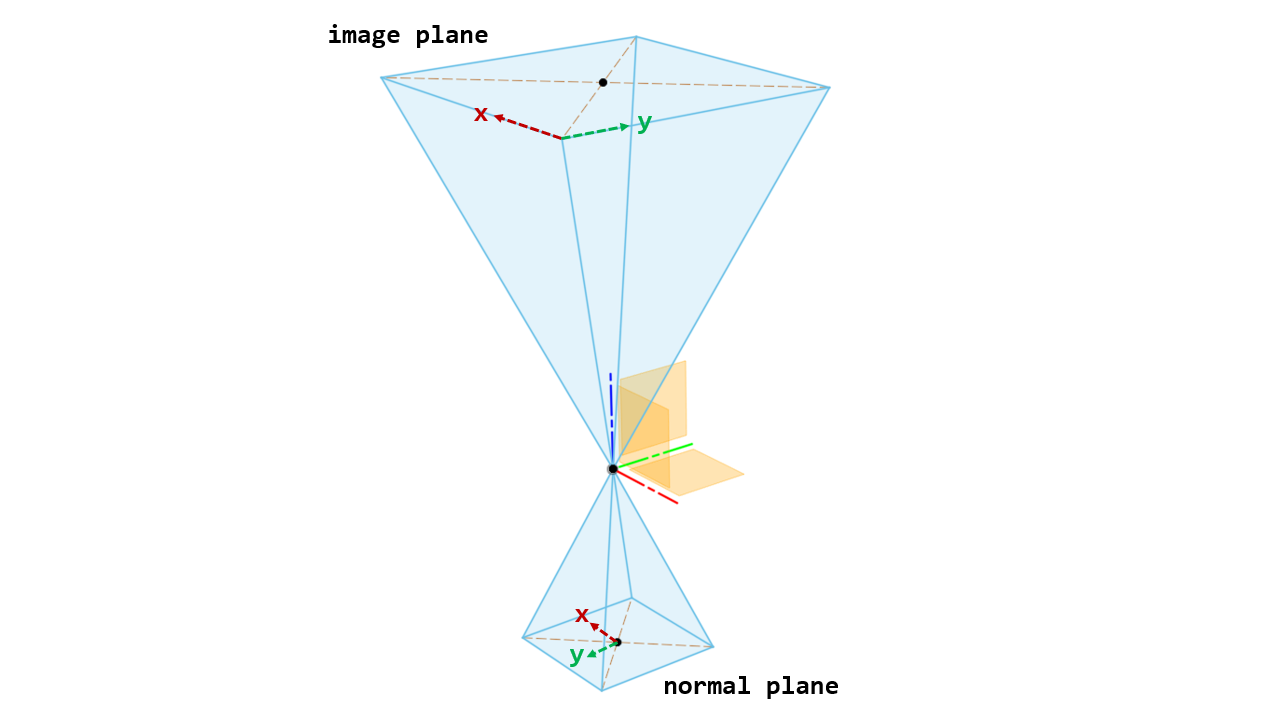  
해당 함수는 그림과 같은 이미지 플레인과 노멀 플레인의 위치 관계를 가시화 해줍니다.  
- 이미지 플레인의 $Z$좌표는 $-f$
- 노멀 플레인의 $Z$좌표는 $-1$
- 이미지 플레인의 원점 $(0, 0)$은 꼭지점에 위치
- 노멀 플레인의 원점 $(0, 0)$은 평면 중앙에 위치
- 이미지 플레인과 노멀 플레인의 $y$좌표계는 반전

In [22]:
def visualize_image_and_normal_plane(H, W, K, axis_lim):
    """
    Image Plane과 Normal Plane을 각각의 3D 그래프에서 시각화하는 함수.
    """
    # --- 이미지 플레인의 좌표 지정 ---
    i, j = torch.meshgrid(
        torch.linspace(0, W-1, W),
        torch.linspace(0, H-1, H)
    )
    i = i.t()
    j = j.t()

    # --- Image Plane 계산 ---
    img_plane_x = i
    img_plane_y = j
    img_plane_z = torch.full_like(i, K[0][0])  # focal length x로 가정
    img_plane = torch.stack([img_plane_x, img_plane_y, img_plane_z], dim=-1)  # (H,W,3)
    img_plane_flat = img_plane.view(-1, 3).cpu().numpy()

    # --- Normal Plane 계산 ---
    norm_plane_x = (img_plane_x-K[0][2])/K[0][0]
    norm_plane_y = (img_plane_y-K[1][2])/K[1][1]
    norm_plane_z = torch.ones_like(img_plane_x)
    dirs = torch.stack([norm_plane_x, -norm_plane_y, -norm_plane_z], -1)  # (H, W, 3)
    dirs_flat = dirs.view(-1, 3).cpu().numpy()

    # --- Image plane 모서리 좌표 가져오기 ---
    img_corner_points = torch.stack([
        img_plane[0, 0],        # 좌상단 (Top-Left)
        img_plane[0, W-1],      # 우상단 (Top-Right)
        img_plane[H-1, 0],      # 좌하단 (Bottom-Left)
        img_plane[H-1, W-1]     # 우하단 (Bottom-Right)
    ], dim=0).cpu().numpy()

    # --- Normal plane 모서리 좌표 가져오기 ---
    corner_points = torch.stack([
        dirs[0, 0],        # 좌상단 (Top-Left)
        dirs[0, W-1],      # 우상단 (Top-Right)
        dirs[H-1, 0],      # 좌하단 (Bottom-Left)
        dirs[H-1, W-1]     # 우하단 (Bottom-Right)
    ], dim=0).cpu().numpy()

    # --- 두 개의 3D 플롯 생성 ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'projection': '3d'})

    # --- (1) Image Plane 시각화 ---
    ax1 = axes[0]
    ax1.set_title("Image Plane")
    # pt.plot_transform(ax=ax1, A2B=np.eye(4), s=0.3, name="CameraCoord")

    ax1.scatter(img_plane_flat[:, 0], img_plane_flat[:, 1], img_plane_flat[:, 2],
                c='green', s=5, alpha=0.5, label="Image plane")
    
    ax1.scatter(img_corner_points[:, 0], img_corner_points[:, 1], img_corner_points[:, 2],
                c='red', s=50, marker='o', label="Corners")

    # 모서리 좌표 텍스트 추가
    for i, (x, y, z) in enumerate(img_corner_points):
        ax1.text(x, y, z, f"({x:.2f}, {y:.2f}, {z:.2f})",
                 color="red", fontsize=9, ha="center")

    ax1.view_init(elev=45, azim=-60)
    ax1.legend()
    ax1.set_xlim([0, W])
    ax1.set_ylim([0, H])
    ax1.set_zlim([0, K[0][0] + 5])
    ax1.set_box_aspect((1, 1, 1))

    # --- (2) Normal Plane 시각화 ---
    ax2 = axes[1]
    ax2.set_title("Normal Plane")
    # pt.plot_transform(ax=ax2, A2B=np.eye(4), s=0.3, name="CameraCoord")

    ax2.scatter(dirs_flat[:, 0], dirs_flat[:, 1], dirs_flat[:, 2],
                c='blue', s=5, alpha=0.6, label="Normal plane")

    ax2.scatter(corner_points[:, 0], corner_points[:, 1], corner_points[:, 2],
                c='red', s=50, marker='o', label="Corners")

    # 모서리 좌표 텍스트 추가
    for i, (x, y, z) in enumerate(corner_points):
        ax2.text(x, y, z, f"({x:.2f}, {y:.2f}, {z:.2f})",
                 color="red", fontsize=9, ha="center")

    ax2.view_init(elev=45, azim=-60)
    ax2.legend()
    ax2.set_xlim([-axis_lim, axis_lim])
    ax2.set_ylim([-axis_lim, axis_lim])
    ax2.set_zlim([-2, 0])
    ax2.set_box_aspect((1, 1, 1))

    plt.show()

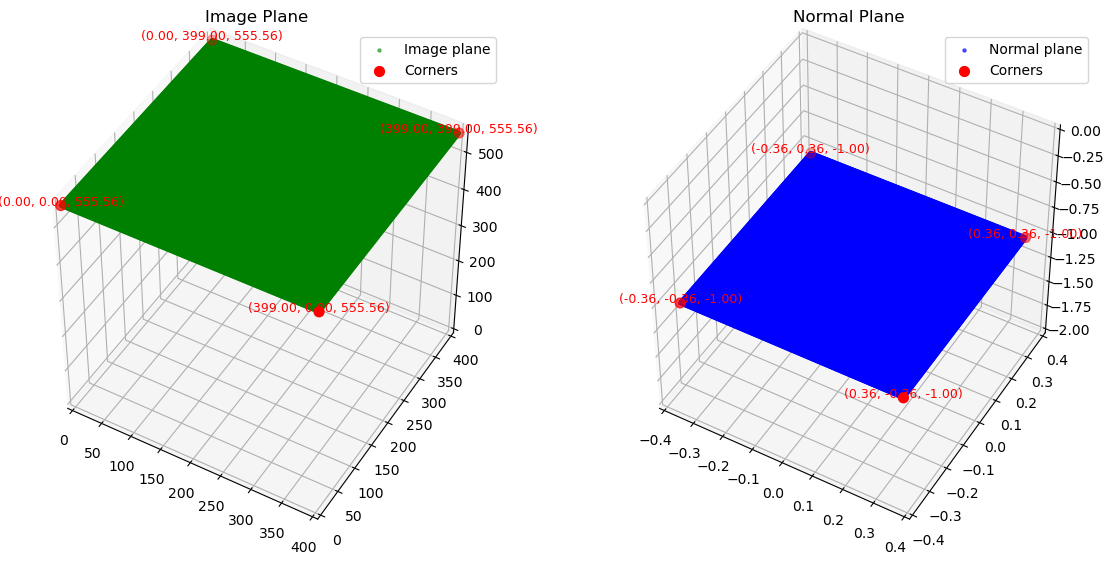

In [23]:
# 실행 예시
visualize_image_and_normal_plane(H, W, K, 0.4)

### visualize_normal_plane()  
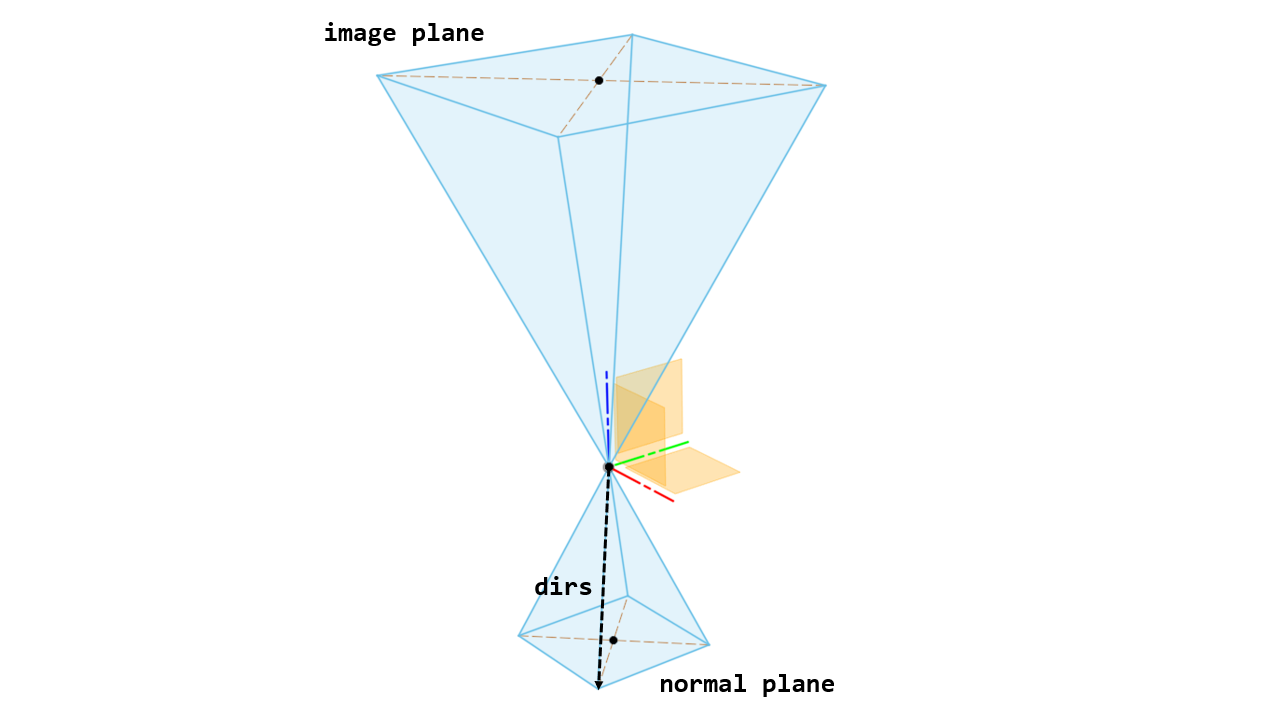  
아래 함수는 **카메라 좌표계**에서 광선을 정의합니다.  
- 광선의 시작점은 초점 $(0, 0, 0)$
- 광선의 방향 벡터는 노멀 플레인의 좌표 $(u^*, v^*, -1)$
- 이 두 점으로 광선 `dirs`를 정의할 수 있음

In [24]:
def visulaize_normal_plane(H, W, K, axis_lim):
    # 이미지 플레인의 좌표 지정
    i, j = torch.meshgrid(
        torch.linspace(0, W-1, W),
        torch.linspace(0, H-1, H)
    )
    i = i.t()
    j = j.t()

    img_plane_x = i
    img_plane_y = j
    img_plane_z = torch.full_like(i, K[0][0]) # z는 focal length x로 가정 (focal length x와 focal length y는 동일한 값이므로)
    img_plane = torch.stack([img_plane_x, img_plane_y, img_plane_z], dim=-1)  # (H,W,3)
    img_plane_flat = img_plane.view(-1, 3).cpu().numpy()

    norm_plane_x = (img_plane_x-K[0][2])/K[0][0]
    norm_plane_y = (img_plane_y-K[1][2])/K[1][1]
    norm_plane_z = torch.ones_like(img_plane_x)
    dirs = torch.stack([norm_plane_x, -norm_plane_y, -norm_plane_z], -1) # (H, W, 3)
    dirs_flat = dirs.view(-1, 3).cpu().numpy()

    # --- Normal plane 모서리 좌표 가져오기 ---
    corner_points = torch.stack([
        dirs[0, 0],        # 좌상단 (Top-Left)
        dirs[0, W-1],      # 우상단 (Top-Right)
        dirs[H-1, 0],      # 좌하단 (Bottom-Left)
        dirs[H-1, W-1]     # 우하단 (Bottom-Right)
    ], dim=0).cpu().numpy()

    corner_labels = ["Top-Left", "Top-Right", "Bottom-Left", "Bottom-Right"]

    # --- 시각화 시작 ---
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    pt.plot_transform(ax=ax, A2B=np.eye(4), s=0.1, name="CameraCoord")

    # --- Normal plane 산점도 ---
    ax.scatter(dirs_flat[:, 0], dirs_flat[:, 1], dirs_flat[:, 2],
               c='blue', s=5, alpha=0.6, label="Normal plane (z=-1)")

    # --- 모서리 좌표 추가 (빨간색 점) ---
    ax.scatter(corner_points[:, 0], corner_points[:, 1], corner_points[:, 2],
               c='red', s=50, marker='o', label="Corners")

    # --- 원점에서 모서리로 향하는 벡터 추가 ---
    for i, (x, y, z) in enumerate(corner_points):
        ax.quiver(0, 0, 0, x, y, z, color='green', arrow_length_ratio=0.1, label="Corner Vectors" if i == 0 else "")

    # --- 모서리 좌표 라벨 추가 ---
    for i, (x, y, z) in enumerate(corner_points):
        ax.text(x, y, z, f"{corner_labels[i]}\n({x:.2f}, {y:.2f}, {z:.2f})", 
                color="black", fontsize=10, ha="center")

    # --- 시각화 설정 ---
    ax.view_init(elev=30, azim=-120)
    ax.legend()
    ax.set_xlim([-axis_lim, axis_lim])
    ax.set_ylim([-axis_lim, axis_lim])
    ax.set_zlim([-2, 0])

    ax.set_box_aspect((1, 1, 1))  # 축 비율 균일화
    plt.show()

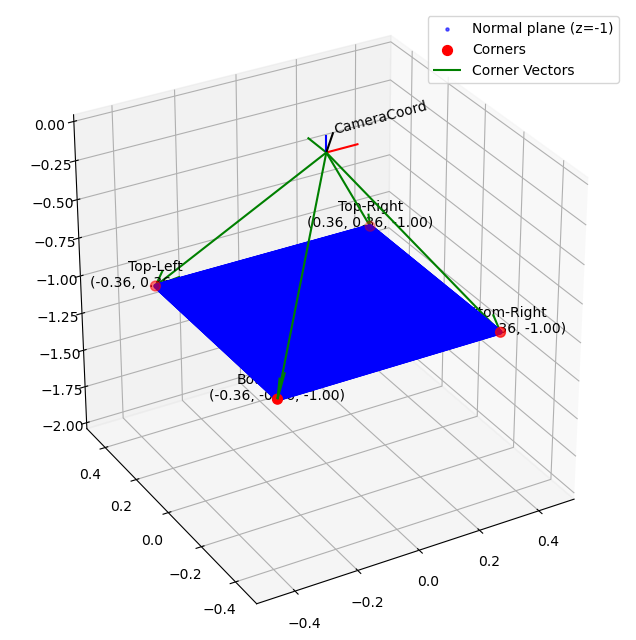

In [25]:
visulaize_normal_plane(H, W, K, 0.5)

### get_rays(), get_rays_np()
위에서 구한 **카메라 좌표계**의 광선과 **c2w 매트릭스**를 이용하여 **월드 좌표계**의 광선을 구합니다.

In [26]:
def get_rays(H, W, K, c2w):
    # 이미지 플레인의 좌표 지정
    i, j = torch.meshgrid(
        torch.linspace(0, W-1, W),
        torch.linspace(0, H-1, H)
    )
    i = i.t()
    j = j.t()

    img_plane_x = i
    img_plane_y = j
    img_plane_z = torch.full_like(i, K[0][0]) # z는 focal length x로 가정 (focal length x와 focal length y는 동일한 값이므로)
    img_plane = torch.stack([img_plane_x, img_plane_y, img_plane_z], dim=-1)  # (H,W,3)
    img_plane_flat = img_plane.view(-1, 3).cpu().numpy()

    norm_plane_x = (img_plane_x-K[0][2])/K[0][0]
    norm_plane_y = (img_plane_y-K[1][2])/K[1][1]
    norm_plane_z = torch.ones_like(img_plane_x)
    dirs = torch.stack([norm_plane_x, -norm_plane_y, -norm_plane_z], -1) # (H, W, 3)
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1) # # c2w @ dir  c2w.dot(dir) dot product, equals to: [c2w.dot(dir) for dir in dirs]
    rays_o = c2w[:3, -1].expand(rays_d.shape)

    return rays_o, rays_d

In [27]:
def get_rays_np(H, W, K, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-K[0][2])/K[0][0], -(j-K[1][2])/K[1][1], -np.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # dirs[..., np.newaxis, :]
    # 원본 dirs가 (H,W,3).
    # [..., np.newaxis, :] → shape (H,W,1,3).

    # c2w[:3,:3]
    # 카메라->월드 행렬에서 3×3 회전부분(R).
    # shape (3,3).

    # 원소별 곱
    # (H,W,1,3) × (3,3)에서 브로드캐스팅으로 “각 픽셀 방향벡터” × “회전행렬 R”을 수행.

    # np.sum(..., -1)
    # 마지막 축(-1=3)에 대해 합 => “dot product”와 동일한 결과.
    # 결과 shape: (H,W,3).
    # 즉, 카메라 좌표에서의 방향을 월드 좌표로 회전시킨 방향 벡터.

    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    # c2w[:3, -1] = t, 즉 카메라 월드 좌표계에서의 원점(평행이동). shape = (3,).
    # np.shape(rays_d) = (H,W,3).
    # np.broadcast_to(..., (H,W,3))
    # => 카메라의 원점(3D) 값을 (H,W,3)로 복사(모든 픽셀 동일 origin).
    # 따라서 rays_o[y,x,:] 전부 t
    # 최종 shape: (H,W,3).

    return rays_o, rays_d

In [28]:
pose = poses[0] # (4, 4)
print(pose[:3, :3]) # c2w의 회전행렬 R (3, 3)
print(pose[:3, -1]) # c2w의 평행이동 t (3, )
print(pose[-1]) # 동차 좌표계에서 4x4 꼴을 맞추기 위해 붙여둔 [ 0 0 0 1 ]

pose = pose[:3, :4] # 의미 없는 [ 0 0 0 1 ]는 제외하고 get_rays_np() 함수의 입력값으로 사용
print(pose)

[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01]]
[-0.05379832  3.8454704   1.2080823 ]
[0. 0. 0. 1.]
[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]]


In [29]:
rays_o, rays_d = get_rays_np(H, W, K, pose)

In [30]:
print(rays_o[0, 0]) # [i, j]의 모든 값이 c2w 행렬에 의해 원점이 이동한 좌표로 동일
print(rays_d[0, 0]) # [i, j]좌표에 대응하는 노말 평면 상의 좌표가 c2w 행렬에 의해 이동한 좌표

[-0.05379832  3.8454704   1.2080823 ]
[ 0.37481973 -1.056785    0.0437651 ]


### visualize_rays_3d()
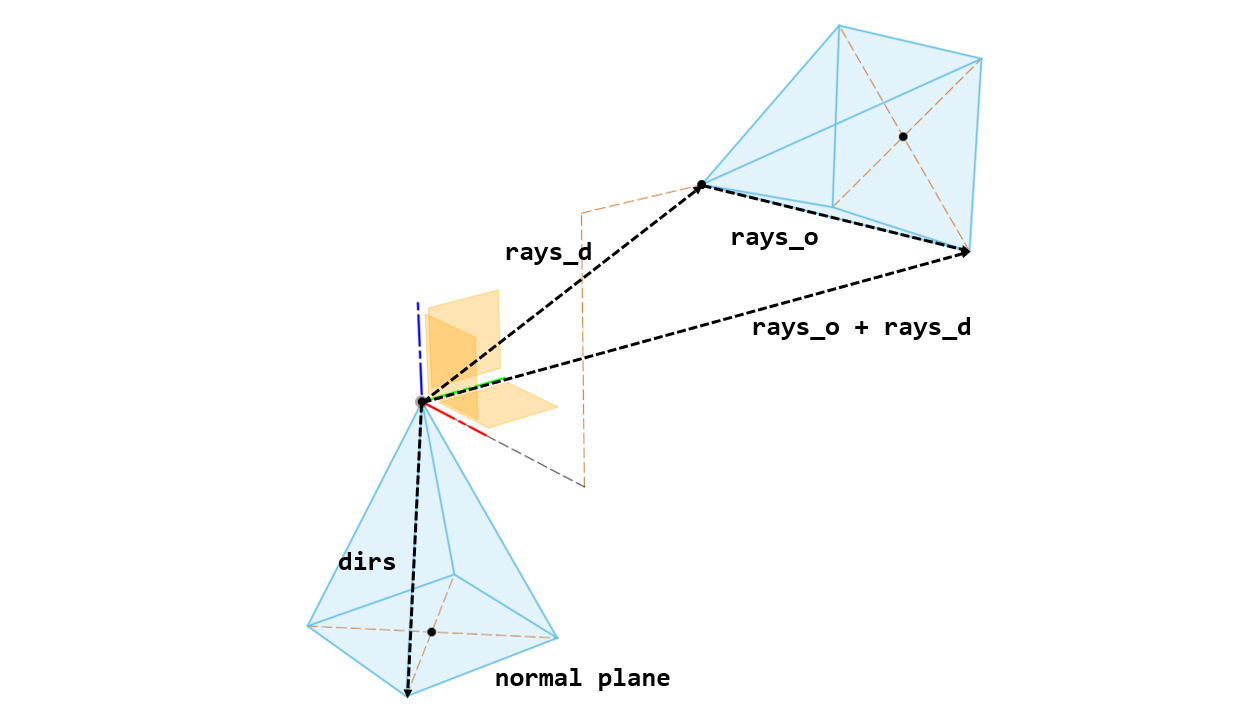  
카메라 좌표계의 노멀 플레인이 월드 좌표계에서 어떻게 이동하는지 가시화하는 함수입니다.
- `rays_d`: c2w의 회전행렬 $R$과 광선의 방향벡터 `dirs`의 곱으로 정의
- `rays_o`: c2w의 평행이동 $t$와 광선의 원점 $(0, 0, 0)$의 합으로 정의
- `rays_d + rays_o`: c2w 행렬에 의해 이동된 노멀 플레인의 좌표

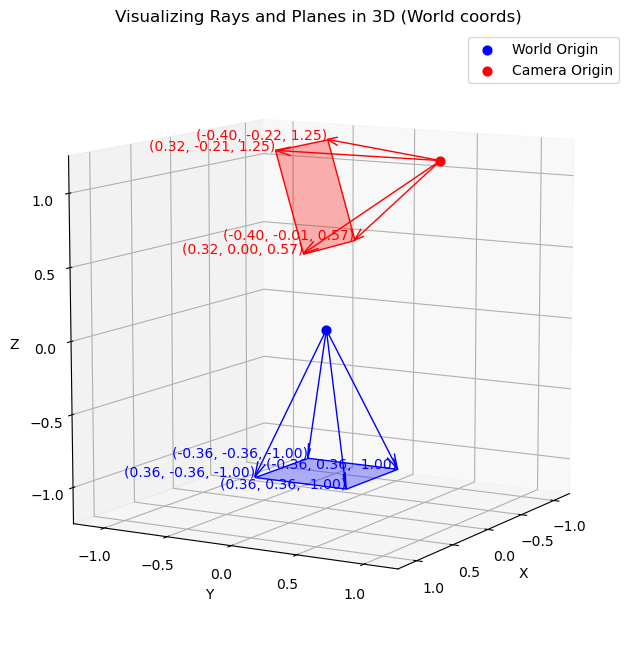

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def get_rays_from_dirs_np(H, W, K, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                       np.arange(H, dtype=np.float32),
                       indexing='xy')
    dirs = np.stack([
        (i - K[0, 2]) / K[0, 0],
        -(j - K[1, 2]) / K[1, 1],
        -np.ones_like(i)
    ], axis=-1)  # (H, W, 3)

    rays_d = np.sum(dirs[..., None, :] * c2w[:3, :3], axis=-1)  # (H, W, 3)
    rays_o = np.broadcast_to(c2w[:3, -1], rays_d.shape)  # (H, W, 3)

    return dirs, rays_o, rays_d

def visualize_rays_3d(H, W, K, c2w, axis_lim=2, elev=30, azim=45):
    dirs, rays_o, rays_d = get_rays_from_dirs_np(H, W, K, c2w)

    corner_indices = [(0, 0), (0, W-1), (H-1, W-1), (H-1, 0)]  # 네 벡터를 시계 방향으로 저장
    cam_origin_camera_coord = np.broadcast_to(np.array([[0, 0, 0]]), (4, 3))
    dirs_corners = np.array([dirs[i, j] for i, j in corner_indices])
    rays_o_corners = np.array([rays_o[i, j] for i, j in corner_indices])
    rays_d_corners = np.array([rays_d[i, j] for i, j in corner_indices])

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    world_origin = np.array([0, 0, 0])
    ax.scatter(*world_origin, c='blue', s=40, label="World Origin")

    for ro, rd in zip(cam_origin_camera_coord, dirs_corners):
        ax.quiver(*ro, *rd, color='blue', linewidth=1, arrow_length_ratio=0.1)
        endpoint = ro + rd
        ax.text(*endpoint, f'({endpoint[0]:.2f}, {endpoint[1]:.2f}, {endpoint[2]:.2f})',
                color='blue', fontsize=10, ha='right')
        
    cam_origin = c2w[:3, 3]
    ax.scatter(*cam_origin, c='red', s=40, label="Camera Origin")
        
    for ro, rd in zip(rays_o_corners, rays_d_corners):
        ax.quiver(*ro, *rd, color='red', linewidth=1, arrow_length_ratio=0.1)
        endpoint = ro + rd
        ax.text(*endpoint, f'({endpoint[0]:.2f}, {endpoint[1]:.2f}, {endpoint[2]:.2f})',
                color='red', fontsize=10, ha='right')
    
    normal_plane_camera = dirs_corners
    normal_plane_world = cam_origin + rays_d_corners

    ax.add_collection3d(Poly3DCollection([normal_plane_camera], color='blue', alpha=0.3))
    ax.add_collection3d(Poly3DCollection([normal_plane_world], color='red', alpha=0.3))

    ax.set_xlim([-axis_lim, axis_lim])
    ax.set_ylim([-axis_lim, axis_lim])
    ax.set_zlim([-axis_lim, axis_lim])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect((1, 1, 1))
    ax.legend()
    plt.title("Visualizing Rays and Planes in 3D (World coords)")
    ax.view_init(elev=elev, azim=azim)
    plt.show()

if __name__ == "__main__":
    H, W = 400, 400
    K = np.array([
        [555.5555, 0., 200.],
        [0., 555.5555, 200.],
        [0., 0., 1.]
    ], dtype=np.float32)

    c2w = np.array([
        [-0.99990219, 0.00419225, -0.01334572, -0.05379832],
        [-0.01398868, -0.29965907, 0.95394367, 0.84547042],
        [-0.0, 0.95403719, 0.29968831, 1.20808232],
        [0., 0., 0., 1.]
    ], dtype=np.float32)

    visualize_rays_3d(H, W, K, c2w, axis_lim=1.2, elev=10, azim=30)

### 이론 정리
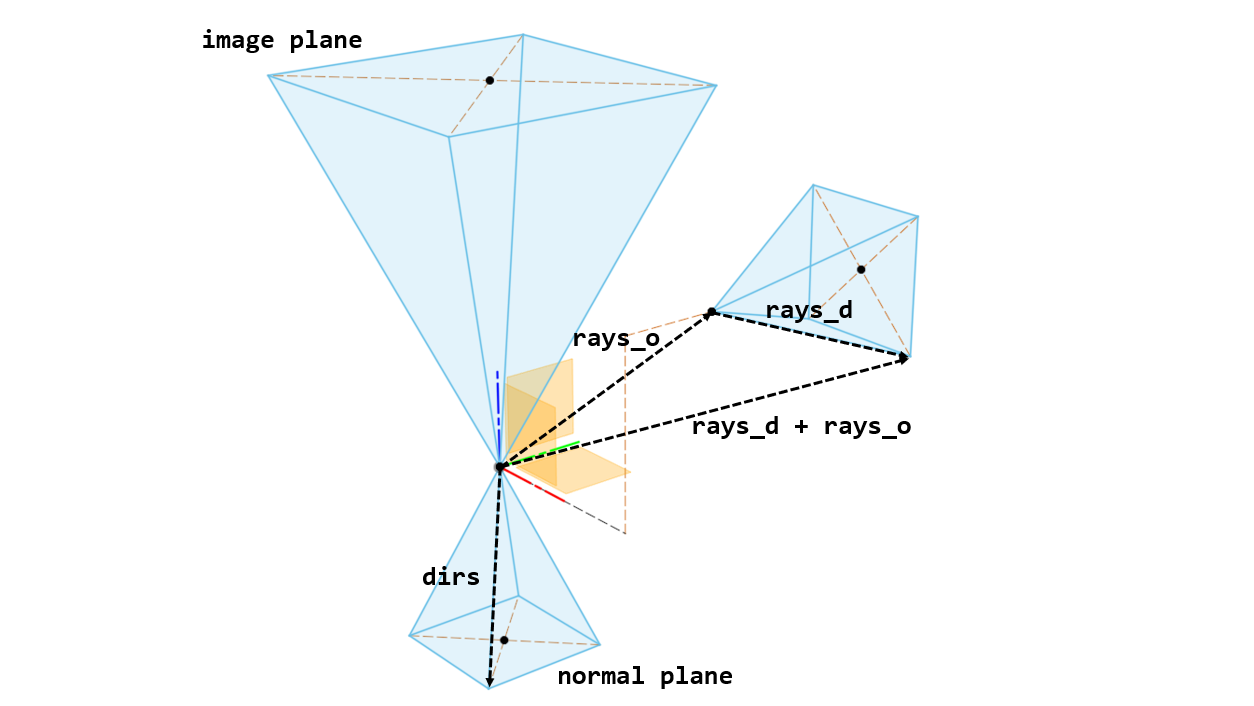  
지금까지 공부한 일련의 과정은 위 그림과 같으며, 크게 두 단계로 나뉜다.
1. 카메라 내부 매트릭스를 이용하여 이미지 플레인의 좌표를 노멀 플레인의 좌표로 대응하고, 이로부터 광선을 정의
2. 카메라 외부 매트릭스(c2w)를 이용하여 정의된 광선을 월드 좌표계로 이동

# 5. NeRF 임베딩 준비
아래의 내용은 광선을 NeRF 네트워크에 임베딩하기 위해 가공하는 과정입니다.  
여러 정보를 합치거나 나누는 간단한 과정이므로 간단히 이해하고 넘어가면 됩니다.  
다음 장에서는 실제로 NeRF에 데이터를 넣어 학습하는 것까지 구현해보겠습니다.

In [32]:
K = None

if args.dataset_type == 'blender':# render_poses은 테스트용 포즈, hwf는 카메라 intrinsic을 만들기 위한 것, i_split은 trian, val, test에 대한 인덱스.
    images, poses, render_poses, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
    print('Loaded Blender Dataset')
    print('images.shape:', images.shape)
    print('render_poses.shape:', render_poses.shape)
    print('hwf:', hwf)
    print('datadir:', args.datadir)

    i_train, i_val, i_test = i_split

    # near, far bound는 2, 6으로 지정.
    near = 2.
    far = 6.

    if args.white_bkgd:
        print('white_bkgd: True')
        images = images[...,:3]*images[...,-1:] + (1. - images[...,-1:]) # 흰 백그라운드로
    else:
        print('white_bkgd: False')
        images = images[...,:3]
    # 이 때 중요한 것은, images의 마지막 차원인 불투명도는 제외하고 가져온다는 것이다.

else:
    print('Unknown dataset type', args.dataset_type, 'exiting')

Loaded Blender Dataset
images.shape: (138, 400, 400, 4)
render_poses.shape: torch.Size([40, 4, 4])
hwf: [400, 400, 555.5555155968841]
datadir: ./data/nerf_synthetic/lego
white_bkgd: True


In [33]:
# Cast intrinsics to right types
H, W, focal = hwf
H, W = int(H), int(W)
hwf = [H, W, focal]

# 카메라 내부 파라미터 설정
if K is None:
    K = np.array([
        [focal, 0, 0.5*W],
        [0, focal, 0.5*H],
        [0, 0, 1]
    ])

print('hwf: ', hwf)
print('K: ', K)

if args.render_test: # 모델을 테스트할 것이라면
    render_poses = np.array(poses[i_test]) # render_poses는 우리가 만들어둔 것이 아니라, test 데이터셋에 있는 c2w 매트릭스들로 덮어씌운다.

hwf:  [400, 400, 555.5555155968841]
K:  [[555.5555156   0.        200.       ]
 [  0.        555.5555156 200.       ]
 [  0.          0.          1.       ]]


In [34]:
N_rand = args.N_rand
use_batching = not args.no_batching

if use_batching:
    rays = np.stack([get_rays_np(H, W, K, p) for p in poses[:,:3,:4]], 0)
    # poses[:,:3,:4]: 3행의 [0 0 0 1]을 절삭한 3x4 행렬. 의미가 없는 데이터이기 때문에 잘라서 함수에 넣어준다.
    # return 값인 rays_o, rays_d를 []로 감싸 [2, 400, 400, 3]차원으로 만든 뒤
    # np.stack을 이용하여 0번째 차원을 추가해 데이터셋 개수만큼 쌓는다.
    # 따라서 rays의 차원은 다음과 같다.
    # [N(trian, test, val을 합친 데이터 개수), 2(광선의 시작점 ro, 광선의 방향 rd), 픽셀들의 행 개수(H), 셀들의 열 개수(W), 좌표(3)] = [138, 2, 400, 400, 3]

    print(rays.shape) # [N, 2, H, W, 3]
    print(images.shape) # [N, H, W, 3], white_bkgd이 True이건 False건 맨 마지막 차원은 절삭한 채 가져온다.
    print(images[:, None].shape) # 1번 차원을 하나 추가

    rays_rgb = np.concatenate([rays, images[:,None]], 1) # 1번 차원에 concat [N, 3(ro & rd & rgb), H, W, 3]
    print(rays_rgb.shape)

    rays_rgb = np.transpose(rays_rgb, [0,2,3,1,4]) # 순서 바꾸기 [N, H, W, 3(ro & rd & rgb), 3]
    print(rays_rgb.shape)

    rays_rgb = np.stack([rays_rgb[i] for i in i_train], 0) # train images only (N')
    print(rays_rgb.shape)

    rays_rgb = np.reshape(rays_rgb, [-1,3,3]) # [N'*H*W, 3(ro & rd & rgb), 3], N': 훈련 이미지 개수
    print(rays_rgb.shape)

    rays_rgb = rays_rgb.astype(np.float32)
    # float32로 변환하면, 신경망이나 GPU에서 계산할 때 메모리 사용량을 줄이고 연산 속도를 높일 수 있습니다.
    # 대부분의 딥러닝 라이브러리(TensorFlow, PyTorch 등)에서 기본적으로 float32를 사용하므로, 데이터 타입을 변환하는 것이 일반적입니다.

    np.random.shuffle(rays_rgb)
    # np.random.shuffle()은 배열의 첫 번째 차원(N'*H*W) 기준으로 데이터를 랜덤하게 섞습니다.

    i_batch = 0

    images = torch.Tensor(images).to(device)
    rays_rgb = torch.Tensor(rays_rgb).to(device)
    
poses = torch.Tensor(poses).to(device)